In [1]:
from src.utils import *

In [2]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide


In [34]:
import sys
import re
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import pickle

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


In [113]:
results_folder = './results/L5_03102022_descr/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map' 

start_folder = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/bin/cell2loc/'
os.chdir(start_folder)
st_path = '../../data/ST_files/ST_matrix_STARsolo_PetterREFs_ensembl/'
image_path = '../../../Images_rev1/'
samples = ['ST3_D1', 'CN56_E1', 'ST3_C2', 'ST3_D2','ST3_E1','ST3_E2', 'CN56_E2', 
           'CN56_C2', 'CN56_D2']
#samples = ['ST3_D1', 'CN56_E1']
pickle_id = 'ST3_CN56'
sample_list = []

In [95]:
ref = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/bin/cell2loc/results/L5_03102022_descr/reference_signatures/sc.h5ad'
ref = sc.read_h5ad(ref)
ref

AnnData object with n_obs × n_vars = 18478 × 11377
    obs: 'Age', 'AnalysisPool', 'CellID', 'Class', 'ClusterName', 'Description', 'Location_based_on', 'Mean Reads per Cell', 'Median UMI Counts per Cell', 'Neurotransmitter', 'Region', 'TaxonomyRank1', 'TaxonomyRank2', 'TaxonomyRank3', 'TaxonomyRank4', 'bio_celltype', 'ChipID', 'SampleID', 'Celltype_assigned', 'value', 'Sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Gene', 'Gene_no_alt', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [106]:
ref.varm['means_per_cluster_mu_fg'].loc['TH']

means_per_cluster_mu_fg_Astrocytes, fibrous; mouse                                              0.001256
means_per_cluster_mu_fg_Astrocytes, protoplasmic; mouse                                         0.001264
means_per_cluster_mu_fg_Axo-axonic, cortex/hippocampus                                          0.106373
means_per_cluster_mu_fg_Basket and bistratified cells, cortex/hippocampus                       0.343503
means_per_cluster_mu_fg_CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus             0.002561
means_per_cluster_mu_fg_CGE-derived neurogliaform cells, cortex/hippocampus                     0.003726
means_per_cluster_mu_fg_Cholinergic interneurons, telencephalon                                 0.413327
means_per_cluster_mu_fg_Cholinergic neurons, midbrain red nucleus                               0.023694
means_per_cluster_mu_fg_D1 medium spiny neurons, striatum                                       0.002052
means_per_cluster_mu_fg_D2 medium spiny neurons, striat

In [107]:
ref.varm['stds_per_cluster_mu_fg'].loc['TH']

stds_per_cluster_mu_fg_Astrocytes, fibrous; mouse                                              0.001453
stds_per_cluster_mu_fg_Astrocytes, protoplasmic; mouse                                         0.001670
stds_per_cluster_mu_fg_Axo-axonic, cortex/hippocampus                                          0.015166
stds_per_cluster_mu_fg_Basket and bistratified cells, cortex/hippocampus                       0.038649
stds_per_cluster_mu_fg_CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus             0.002876
stds_per_cluster_mu_fg_CGE-derived neurogliaform cells, cortex/hippocampus                     0.003010
stds_per_cluster_mu_fg_Cholinergic interneurons, telencephalon                                 0.102164
stds_per_cluster_mu_fg_Cholinergic neurons, midbrain red nucleus                               0.037977
stds_per_cluster_mu_fg_D1 medium spiny neurons, striatum                                       0.002431
stds_per_cluster_mu_fg_D2 medium spiny neurons, striatum        

In [108]:
st_pickle = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/bin/cell2loc/results/L5_03102022_descr/reference_signatures/adata_vis_ST3_CN56.pickle'
st_pickle

'/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/bin/cell2loc/results/L5_03102022_descr/reference_signatures/adata_vis_ST3_CN56.pickle'

In [110]:
adata_vis = pickle.load(open(st_pickle, 'rb'))
adata_vis

AnnData object with n_obs × n_vars = 7322 × 7881
    obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
    var: 'gene_ids', 'Gene_no_alt'
    uns: 'spatial'
    obsm: 'spatial'

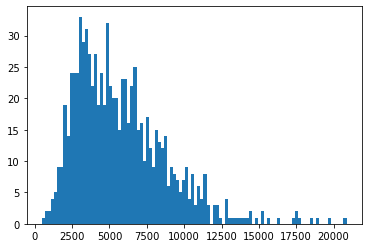

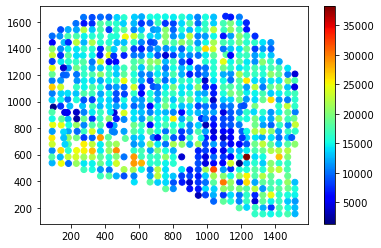

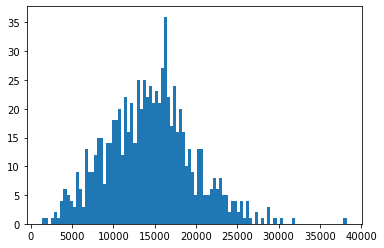

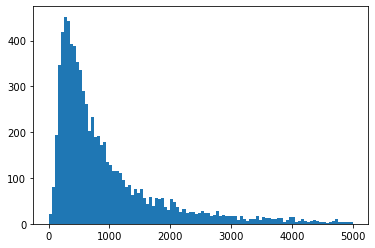

In [142]:
sample = samples[7]
x = select_slide(adata_vis, sample)
c = np.sum(adata_vis[adata_vis.obs['sample'] == sample, :].X, axis=1)
# c = x[:, 'PENK'].X
adata_vis.obsm['spatial']
plt.scatter(x.obsm['spatial'][:, 0], x.obsm['spatial'][:, 1], c=c, cmap='jet')
plt.colorbar()
plt.show()
plt.hist(x.X.sum(axis=1).flatten(), bins=100)
plt.show()
plt.clf()
plt.hist(x.X.sum(axis=0).flatten(), range=[0, 5000], bins=100)
plt.show()

In [16]:
sample_list

[]

In [9]:
sample_list[0].var

gene_ids  passed_min_feature_presence
gene_ids                                                   
5330417C22RIK    5330417C22RIK                         True
AAAS                      AAAS                         True
AABR07000222.1  AABR07000222.1                         True
AABR07000398.1  AABR07000398.1                         True
AABR07000402.1  AABR07000402.1                         True
...                        ...                          ...
ZXDC                      ZXDC                         True
ZYG11B                  ZYG11B                         True
ZYX                        ZYX                         True
ZZEF1                    ZZEF1                         True
ZZZ3                      ZZZ3                         True

[10633 rows x 2 columns]

In [17]:
for sample in samples:
    print(sample)
    adata = STLoader(st_path, sample)
    adata.add_image(image_path)
    print('adding image')
    adata.correct_feature_position(image_path)
    adata.filter_by_expression()
    adata = adata.anndata
    sample_list.append(adata)

    
#adata_vis = st_concat_anndata(sample_list, samples)

    #adata_vis = merge_gene_symbol_duplicates(adata_vis.anndata, symbol_column='gene_ids')

ST3_D1
dataset loaded
Feature x Gene matrix transposed
adding image
Filtering features and genes by expression. Positions with less than 300 transcripts are discarded as well as genes that do not reach at least 2 in at least 4 features
4 features and 27739 genes dropped
CN56_E1
dataset loaded
Feature x Gene matrix transposed
adding image
Filtering features and genes by expression. Positions with less than 300 transcripts are discarded as well as genes that do not reach at least 2 in at least 4 features
41 features and 26476 genes dropped


In [18]:
adata_vis = st_concat_anndata(sample_list, samples)

<class 'anndata._core.anndata.AnnData'>


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [21]:
adata_vis.transalate_ensembl()
adata_vis.anndata.var

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-9990...done.


gene_ids  passed_min_feature_presence  \
symbol                                                        
GCLC           ENSG00000001084                         True   
RBM6           ENSG00000004534                         True   
CDC27          ENSG00000004897                         True   
HOXA11         ENSG00000005073                         True   
THSD7A         ENSG00000005108                         True   
...                        ...                          ...   
Aldh4a1     ENSRNOG00000061876                         True   
Cenpp       ENSRNOG00000062220                         True   
Il1rapl2    ENSRNOG00000062221                         True   
FAM120C     ENSRNOG00000062231                         True   
Rpl24-ps11  ENSRNOG00000062253                         True   

                                                       name      symbol  \
symbol                                                                    
GCLC            glutamate-cysteine ligase catalytic subunit        GCLC   
RBM6                            RNA binding motif protein 6        RBM6   
CDC27                                cell division cycle 27       CDC27   
HOXA11                                         homeobox A11      HOXA11   
THSD7A           thrombospondin type 1 domain containing 7A      THSD7A   
...                                                     ...         ...   
Aldh4a1          aldehyde dehydrogenase 4 family, member A1     Aldh4a1   
Cenpp                                  centromere protein P       Cenpp   
Il1rapl2    interleukin 1 receptor accessory protein-like 2    Il1rapl2   
FAM120C                family with sequence similarity 120C     FAM120C   
Rpl24-ps11             ribosomal protein L24, pseudogene 11  Rpl24-ps11   

            species  
symbol               
GCLC           ENSG  
RBM6           ENSG  
CDC27          ENSG  
HOXA11         ENSG  
THSD7A         ENSG  
...             ...  
Aldh4a1     ENSRNOG  
Cenpp       ENSRNOG  
Il1rapl2    ENSRNOG  
FAM120C     ENSRNOG  
Rpl24-ps11  ENSRNOG  

[9574 rows x 5 columns]

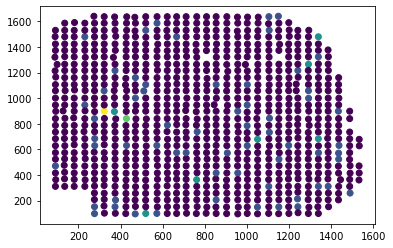

In [39]:
sample = samples[5]
x = select_slide(adata_vis, sample)
#c = np.sum(adata_vis[adata_vis.obs['sample'] == sample, :].X, axis=1)
c = x[:, 'COL1A1'].X
adata_vis.obsm['spatial']
plt.scatter(x.obsm['spatial'][:, 0], x.obsm['spatial'][:, 1], c=c)
plt.show()

In [33]:
adata_vis.anndata.uns['merged'] = False
adata_vis.anndata.uns['merged']

False

In [3]:
sc_data_folder = './data/'
results_folder = './results/mouse_brain_snrna/'

In [57]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(sc_data_folder + 'snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)

In [58]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

In [59]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 40532 × 31053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

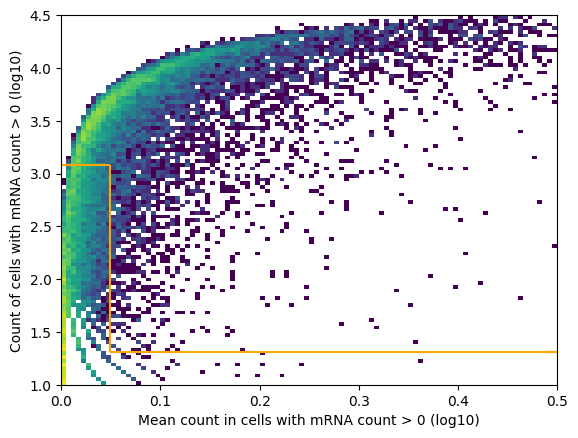

In [60]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [61]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(40532, 12844)

In [62]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

In [63]:
adata_snrna_raw.raw = adata_snrna_raw



In [64]:
#########################
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
sc.pp.log1p(adata_snrna_raw)

sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw.obsm['X_pca'] = adata_snrna_raw.obsm['X_pca'][:, :]
adata_snrna_raw.varm['PCs'] = adata_snrna_raw.varm['PCs'][:, :]
#########################

# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments)
import bbknn
bbknn.bbknn(adata_snrna_raw, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 79)
sc.tl.umap(adata_snrna_raw, min_dist = 0.8, spread = 1.5)

#########################

adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].argsort(),:]

ModuleNotFoundError: No module named 'bbknn'

In [ ]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

In [4]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]  

In [4]:
import scanpy as sc
import os
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import loompy
import pickle

import cell2location
import scvi
from PIL import Image

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFsx

Global seed set to 0


In [5]:
results_folder = './results/unique_mouse_rat_sc/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map' 

In [21]:
st_path = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/data/ST_files/ST_matrix_STARsolo_correct_PetterREFs_Unique/'
image_path = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Images_rev1/corrected_png/'
samples = [exp.split('_stdata')[0] for exp in os.listdir(st_path) if '_stdata' in exp]

In [22]:
samples = ['ST3_E2', 'ST3_D1', 'CN56_E1', 'CN57_E2']

In [23]:
slides = []
for sample in samples:
    print('Loading well', sample)
    slide = SpatialSlide(st_path, sample)
    slide.add_image(image_path)
    slides.append(slide.array)

slides

Loading well ST3_E2


/tmp/ipykernel_119816/3316417790.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.array = anndata.AnnData(obs=obs, var=var, X=X)
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Loading well ST3_D1


/tmp/ipykernel_119816/3316417790.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.array = anndata.AnnData(obs=obs, var=var, X=X)
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Loading well CN56_E1


/tmp/ipykernel_119816/3316417790.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.array = anndata.AnnData(obs=obs, var=var, X=X)
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Loading well CN57_E2


/tmp/ipykernel_119816/3316417790.py:23: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.array = anndata.AnnData(obs=obs, var=var, X=X)
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[AnnData object with n_obs × n_vars = 839 × 9915
     obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
     var: 'SYMBOL', 'total_counts', 'n_genes_by_counts'
     uns: 'sample', 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 944 × 10691
     obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
     var: 'SYMBOL', 'total_counts', 'n_genes_by_counts'
     uns: 'sample', 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 780 × 14395
     obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
     var: 'SYMBOL', 'total_counts', 'n_genes_by_counts'
     uns: 'sample', 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 597 × 12085
     obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
     var: 'SYMBOL', 'total_counts', 'n_genes_by_counts'
     uns: 'sample', 'spatial'
     obsm: 'spatial']

In [24]:
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=samples,
    index_unique=None
)

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
adata.var

SYMBOL  total_counts-CN56_E1  n_genes_by_counts-CN56_E1  \
AAAS                  AAAS                 193.0                        165   
AABR07000398  AABR07000398               70769.0                        779   
AABR07001099  AABR07001099                 423.0                        300   
AABR07001382  AABR07001382                2775.0                        700   
AABR07001432  AABR07001432                 925.0                        484   
...                    ...                   ...                        ...   
ZUP1                  ZUP1                 186.0                        163   
ZWINT                ZWINT               18459.0                        778   
ZYX                    ZYX                 346.0                        284   
ZZEF1                ZZEF1                 407.0                        304   
ZZZ3                  ZZZ3                 202.0                        177   

              total_counts-CN57_E2  n_genes_by_counts-CN57_E2  \
AAAS                         111.0                         96   
AABR07000398               31504.0                        597   
AABR07001099                 184.0                        156   
AABR07001382                 876.0                        431   
AABR07001432                 105.0                         90   
...                            ...                        ...   
ZUP1                         112.0                        100   
ZWINT                      14814.0                        597   
ZYX                          337.0                        245   
ZZEF1                        206.0                        175   
ZZZ3                          98.0                         88   

              total_counts-ST3_D1  n_genes_by_counts-ST3_D1  \
AAAS                         96.0                        87   
AABR07000398              96130.0                       943   
AABR07001099                188.0                       170   
AABR07001382               1509.0                       689   
AABR07001432                448.0                       287   
...                           ...                       ...   
ZUP1                         96.0                        92   
ZWINT                     12541.0                       944   
ZYX                         230.0                       191   
ZZEF1                       199.0                       164   
ZZZ3                        110.0                       101   

              total_counts-ST3_E2  n_genes_by_counts-ST3_E2  
AAAS                         53.0                        49  
AABR07000398              42748.0                       839  
AABR07001099                178.0                       156  
AABR07001382                828.0                       485  
AABR07001432                371.0                       244  
...                           ...                       ...  
ZUP1                         83.0                        81  
ZWINT                     10284.0                       827  
ZYX                         222.0                       181  
ZZEF1                        79.0                        76  
ZZZ3                         88.0                        83  

[8947 rows x 9 columns]

In [26]:
adata_vis = adata.copy()
adata_vis

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3160 × 8947
    obs: 'feature', 'array_row', 'array_col', 'in_tissue', 'sample'
    var: 'SYMBOL', 'total_counts-CN56_E1', 'n_genes_by_counts-CN56_E1', 'total_counts-CN57_E2', 'n_genes_by_counts-CN57_E2', 'total_counts-ST3_D1', 'n_genes_by_counts-ST3_D1', 'total_counts-ST3_E2', 'n_genes_by_counts-ST3_E2'
    uns: 'spatial'
    obsm: 'spatial'

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
OMP: Info #276: omp_set_nested routine deprecate

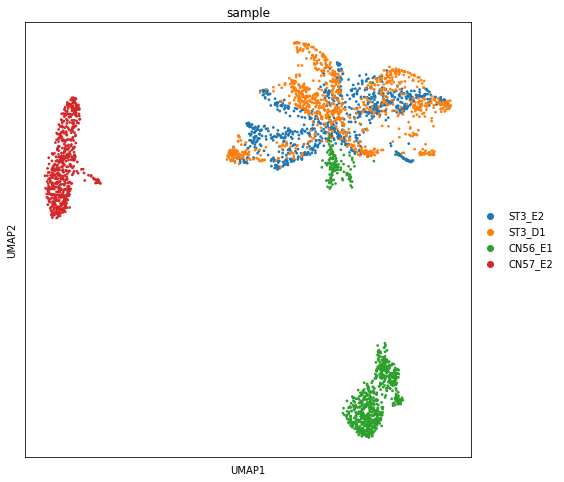

In [27]:
adata_vis_plt = adata.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():

    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)

    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True

# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

In [28]:
## load single cell data 
sc_path = '/media/Dropbox/MNM projects/Spatial transcriptomics project/Data analysis/Complete_ST_pipeline/data/stereoscope_reference/single_cell_data/curated/Linnarsson_VM-STR-Ctx-selection_23082021/'
filename = sc_path.split('/')[-2] + '.pkl'
    
if '.pkl' not in str(os.listdir(sc_path)):
    print('new anndata')
    sc_obs = pd.read_csv(sc_path + [file for file in os.listdir(sc_path) if 'mta_data' in file][0], sep='\t', 
                     header=0, 
                     index_col=False)
    sc_obs.index = sc_path.split('/')[-2] + '_' + sc_obs['cell']
    
    sc_cnt = pd.read_csv(sc_path + [file for file in os.listdir(sc_path) if 'cnt_data' in file][0], sep='\t',
                    index_col=0,
                    header=0)
    
    sc_var = pd.DataFrame(sc_cnt.columns)
    sc_var.columns = ['SYMBOL']
    sc_var.index = sc_var['SYMBOL']
    
    sc_adata = anndata.AnnData(obs=sc_obs, var=sc_var, X = sc_cnt.iloc[:,:].to_numpy())
    

    outfile = open(sc_path + filename,'wb')
    pickle.dump(sc_adata, outfile)
    outfile.close()
else:
    print('found a pickle!')
    infile = open(sc_path + filename,'rb')
    sc_adata = pickle.load(infile)
    infile.close()

found a pickle!


In [29]:
sc_adata.obs['Sample'] = 'Linnarsson'

In [44]:
sc_adata.var

SYMBOL
SYMBOL                      
0610007P14RIK  0610007P14RIK
0610009B22RIK  0610009B22RIK
0610009L18RIK  0610009L18RIK
0610009O20RIK  0610009O20RIK
0610010F05RIK  0610010F05RIK
...                      ...
ZYG11A                ZYG11A
ZYG11B                ZYG11B
ZYX                      ZYX
ZZEF1                  ZZEF1
ZZZ3                    ZZZ3

[27794 rows x 1 columns]

In [47]:
# Column name containing cell type annotations
adata_file = f"{ref_run_name}/sc.h5ad"
sc_adata = sc.read_h5ad(adata_file)
covariate_col_names = 'bio_celltype'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = sc_adata.var.copy()
print(inf_aver)
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in sc_adata.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in sc_adata.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * sc_adata.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

                      SYMBOL  n_cells  nonz_mean
SYMBOL                                          
0610007P14RIK  0610007P14RIK     3762   1.371611
0610009B22RIK  0610009B22RIK     3523   1.387454
0610009L18RIK  0610009L18RIK     1183   1.142012
0610009O20RIK  0610009O20RIK     1119   1.096515
0610010F05RIK  0610010F05RIK     1204   1.147841
...                      ...      ...        ...
ZYG11A                ZYG11A        0        NaN
ZYG11B                ZYG11B     3256   1.477887
ZYX                      ZYX      981   1.146789
ZZEF1                  ZZEF1     2237   1.237819
ZZZ3                    ZZZ3     1151   1.089487

[27794 rows x 3 columns]


KeyError: "None of [Index(['means_cov_effect_bio_celltype_Basket and bistratified cells, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Subventricular zone radial glia-like cells',\n       'means_cov_effect_bio_celltype_Cortical projection neurons; mouse',\n       'means_cov_effect_bio_celltype_Immune cells; mouse',\n       'means_cov_effect_bio_celltype_Telencephalon astrocytes, fibrous; mouse',\n       'means_cov_effect_bio_celltype_Vascular leptomeningeal cells; mouse',\n       'means_cov_effect_bio_celltype_Vascular; mouse',\n       'means_cov_effect_bio_celltype_Interneuron-selective interneurons, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Sleep-active, long-range projection interneurons, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_R-LM border Cck interneurons, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Oligodendrocytes; mouse',\n       'means_cov_effect_bio_celltype_Hippocamposeptal projection, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_CGE-derived neurogliaform cells, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Neuronal intermidate progenitor cells (decoy)',\n       'means_cov_effect_bio_celltype_Axo-axonic, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Ivy and MGE-derived neurogliaform cells, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Non-telencephalon astrocytes, fibrous; mouse',\n       'means_cov_effect_bio_celltype_Inhibitory neurons, septal nucleus (decoy)',\n       'means_cov_effect_bio_celltype_Non-border Cck interneurons, cortex/hippocampus (decoy)',\n       'means_cov_effect_bio_celltype_Telencephalon astrocytes, protoplasmic; mouse',\n       'means_cov_effect_bio_celltype_Cholinergic interneurons; mouse',\n       'means_cov_effect_bio_celltype_Inhibitory neurons, midbrain (decoy)',\n       'means_cov_effect_bio_celltype_Non-telencephalon astrocytes, protoplasmic; mouse',\n       'means_cov_effect_bio_celltype_D1 Medium Spiny Neurons; mouse',\n       'means_cov_effect_bio_celltype_D2 Medium Spiny Neurons; mouse',\n       'means_cov_effect_bio_celltype_Patch D1/D2 neurons, striatum (decoy)',\n       'means_cov_effect_bio_celltype_Dopaminergic neurons; mouse',\n       'means_cov_effect_bio_celltype_Cholinergic neurons, midbrain red nucleus (decoy)'],\n      dtype='object')] are in the [columns]"

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


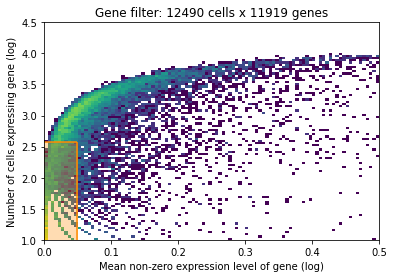

In [31]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
#adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

# Read data
adata_ref = sc_adata.copy()

from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [32]:
adata_ref

AnnData object with n_obs × n_vars = 12490 × 11919
    obs: 'cell', 'bio_celltype', 'Sample'
    var: 'SYMBOL', 'n_cells', 'nonz_mean'

In [33]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='bio_celltype'
                       )
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'bio_celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 12490 │
│          n_vars          │ 11919 │
│         n_batch          │   1   │
│         n_labels         │  29   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │ Linnarsson │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                                    labels State Registry                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Source Locati ┃                            Categories                            ┃ scvi-t ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ adata.obs['bi │              Axo-axonic, cortex/hippocampus (decoy)              │   0    │
│               │    Basket and bistratified cells, cortex/hippocampus (decoy)     │   1    │
│               │ CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus (dec │   2    │
│               │   CGE-derived neurogliaform cells, cortex/hippocampus (decoy)    │   3    │
│               │                 Cholinergic interneurons; mouse                  │   4    │
│               │        Cholinergic neurons, midbrain red nucleus (decoy)         │   5    │
│               │                Cortical projection neurons; mouse                │   6    │
│               │                  D1 Medium Spiny Neurons; mouse                  │   7    │
│               │                  D2 Medium Spiny Neurons; mouse                  │   8    │
│               │                   Dopaminergic neurons; mouse                    │   9    │
│               │     Hippocamposeptal projection, cortex/hippocampus (decoy)      │   10   │
│               │                       Immune cells; mouse                        │   11   │
│               │               Inhibitory neurons, midbrain (decoy)               │   12   │
│               │            Inhibitory neurons, septal nucleus (decoy)            │   13   │
│               │  Interneuron-selective interneurons, cortex/hippocampus (decoy)  │   14   │
│               │ Ivy and MGE-derived neurogliaform cells, cortex/hippocampus (dec │   15   │
│               │          Neuronal intermidate progenitor cells (decoy)           │   16   │
│               │     Non-border Cck interneurons, cortex/hippocampus (decoy)      │   17   │
│               │           Non-telencephalon astrocytes, fibrous; mouse           │   18   │
│               │        Non-telencephalon astrocytes, protoplasmic; mouse         │   19   │
│               │                     Oligodendrocytes; mouse                      │   20   │
│               │              Patch D1/D2 neurons, striatum (decoy)               │   21   │
│               │     R-LM border Cck interneurons, cortex/hippocampus (decoy)     │   22   │
│               │ Sleep-active, long-range projection interneurons, cortex/hippoca │   23   │
│               │            Subventricular zone radial glia-like cells            │   24   │
│               │             Telencephalon astrocytes, fibrous; mouse             │   25   │
│               │          Telencephalon astrocytes, protoplasmic; mouse           │   26   │
│               │               Vascular leptomeningeal cells; mouse               │   27   │
│               │                         Vascular; mouse                          │   28   │
└───────────────┴──────────────────────────────────────────────────────────────────┴────────┘

In [45]:
mod.train(max_epochs=100, use_gpu=True, batch_size=1000)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/100:   1%|           | 1/100 [00:01<02:42,  1.65s/it, v_num=1, elbo_train=6.77e+7]

/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 100/100: 100%|███████| 100/100 [02:38<00:00,  1.59s/it, v_num=1, elbo_train=6.64e+7]


In [48]:
dir(mod)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adata',
 '_adata_manager',
 '_check_if_trained',
 '_compute_cluster_averages',
 '_data_loader_cls',
 '_export2adata',
 '_get_init_params',
 '_get_most_recent_anndata_manager',
 '_get_obs_plate_return_sites',
 '_get_obs_plate_sites',
 '_get_one_posterior_sample',
 '_get_posterior_samples',
 '_get_setup_method_args',
 '_get_user_attributes',
 '_make_data_loader',
 '_model_summary_string',
 '_optim_param',
 '_per_instance_manager_store',
 '_posterior_quantile',
 '_posterior_quantile_minibatch',
 '_posterior_samples_minibatch',
 '_register_manager_for_instance',
 '_setup_adata_manager_s

In [53]:
mod.plot_history()

KeyError: 'elbo_train'

In [46]:
mod.plot_history(20)

KeyError: 'elbo_train'

In [39]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████| 999/999 [00:20<00:00, 48.51it/s]


'./results/unique_mouse_rat_sc//reference_signatures/sc.h5ad'

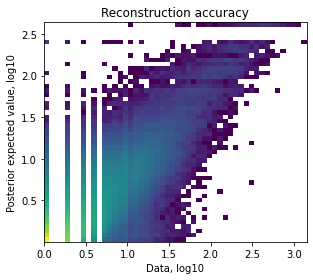

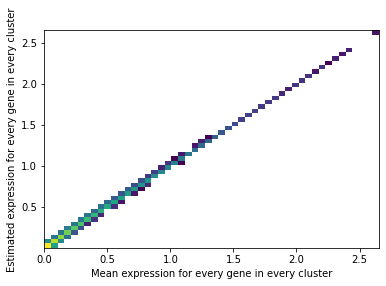

In [40]:
mod.plot_QC()

In [41]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/unique_mouse_rat_sc//reference_signatures/model.pt already downloaded
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|         | 1/1000 [00:00<06:02,  2.76it/s, v_num=1, elbo_train=6.82e+7]


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [42]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Axo-axonic, cortex/hippocampus (decoy)  \
SYMBOL                                                  
0610007P14RIK                                0.476343   
0610009B22RIK                                0.443716   
0610009L18RIK                                0.180794   
0610009O20RIK                                0.100562   
0610010F05RIK                                0.143592   

               Basket and bistratified cells, cortex/hippocampus (decoy)  \
SYMBOL                                                                     
0610007P14RIK                                           0.402461           
0610009B22RIK                                           0.440076           
0610009L18RIK                                           0.195870           
0610009O20RIK                                           0.114566           
0610010F05RIK                                           0.162402           

               CGE-derived neurogliaform cells Cxcl14+, cortex/hippocampus (decoy)  \
SYMBOL                                                                               
0610007P14RIK                                           0.524673                     
0610009B22RIK                                           0.390905                     
0610009L18RIK                                           0.069279                     
0610009O20RIK                                           0.137754                     
0610010F05RIK                                           0.087016                     

               CGE-derived neurogliaform cells, cortex/hippocampus (decoy)  \
SYMBOL                                                                       
0610007P14RIK                                           0.557308             
0610009B22RIK                                           0.437474             
0610009L18RIK                                           0.099433             
0610009O20RIK                                           0.077898             
0610010F05RIK                                           0.070998             

               Cholinergic interneurons; mouse  
SYMBOL                                          
0610007P14RIK                         0.545771  
0610009B22RIK                         1.108173  
0610009L18RIK                         0.220712  
0610009O20RIK                         0.156937  
0610010F05RIK                         0.582984

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
mod.plot_QC()

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'ST3_E1')

# plot in spatial coordinates
with mpl.rc_context({'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['D1 Medium Spiny Neurons; mouse', 'D2 Medium Spiny Neurons; mouse', 
                         'Dopaminergic neurons; mouse', 'Oligodendrocytes; mouse',
                         'Vascular leptomeningeal cells; mouse', 'Subventricular zone radial glia-like cells', 
                         'Telencephalon astrocytes, fibrous; mouse', 'Cortical projection neurons; mouse'],
                  ncols=4, size=1.3,                   
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

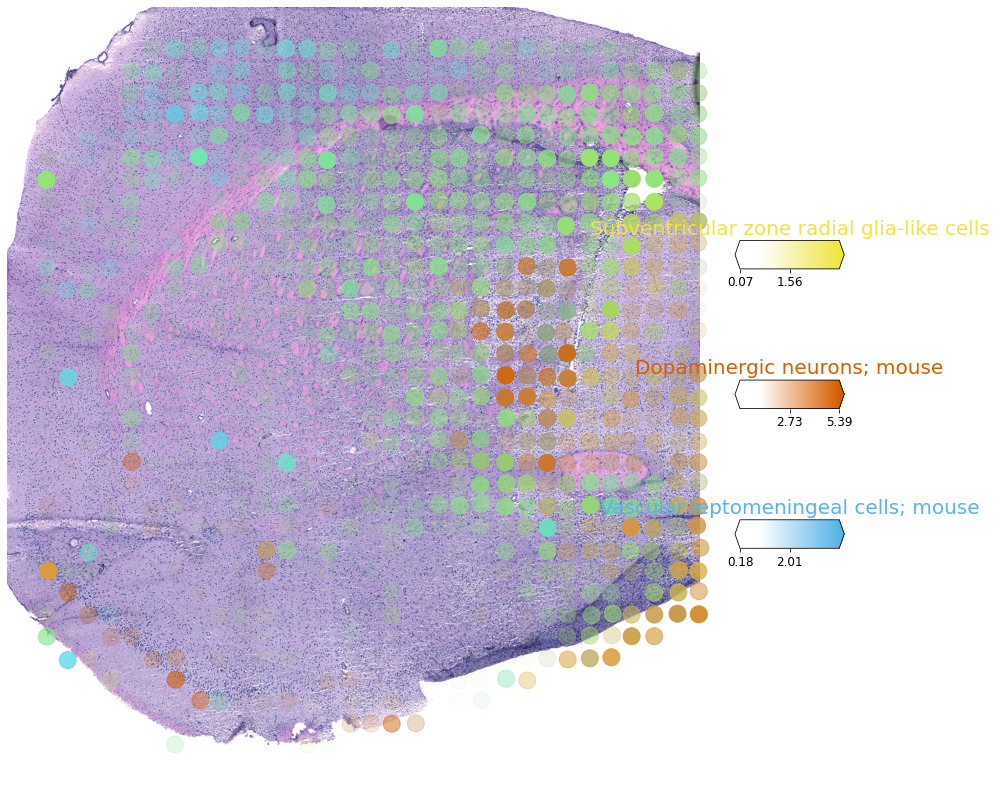

In [271]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Subventricular zone radial glia-like cells', 
                'Dopaminergic neurons; mouse', 
                'Vascular leptomeningeal cells; mouse']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'ST3_E1')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=17,
        colorbar_position='right'
    )



In [272]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

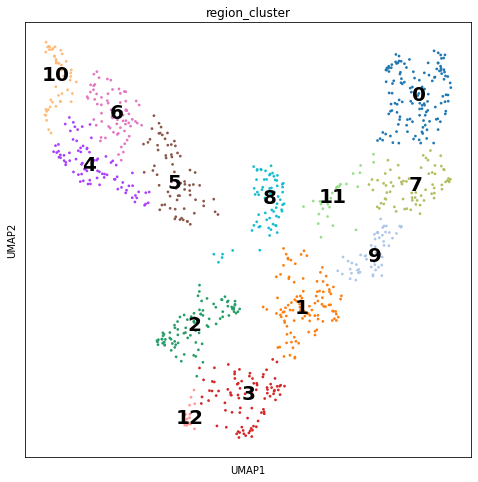

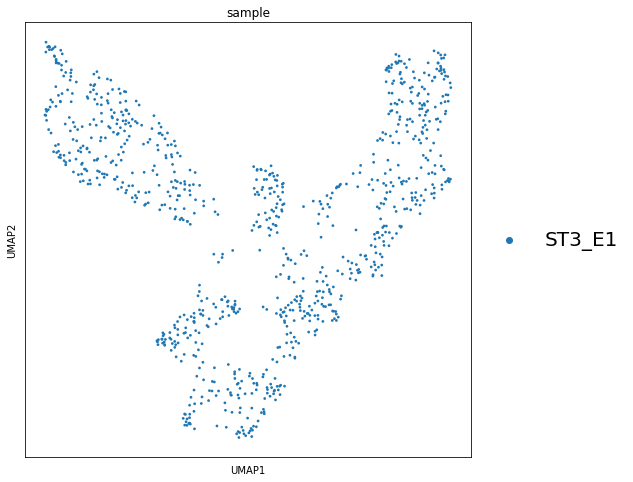

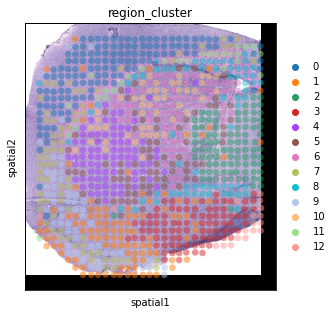

In [273]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [274]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_930locations_29factors


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_930locations_29factors


/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/lcadmin/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


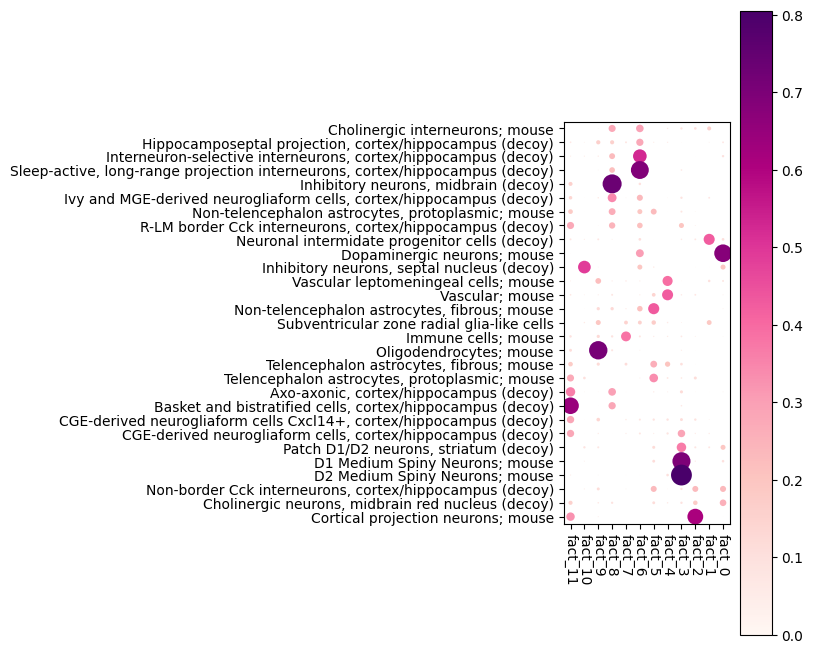

In [275]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [276]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/mouse_rat_sc//cell2location_map/sp.h5ad'

In [285]:
adata_vis.var

SYMBOL  MT_gene
gene_ids                             
5330417C22RIK  5330417C22RIK    False
A2M                      A2M    False
AACS                    AACS    False
AAGAB                  AAGAB    False
AAK1                    AAK1    False
...                      ...      ...
ZXDC                    ZXDC    False
ZYG11B                ZYG11B    False
ZYX                      ZYX    False
ZZEF1                  ZZEF1    False
ZZZ3                    ZZZ3    False

[9218 rows x 2 columns]

In [289]:
adata_vis.obsm['spatial'] = adata_vis.obsm['spatial']*0.95

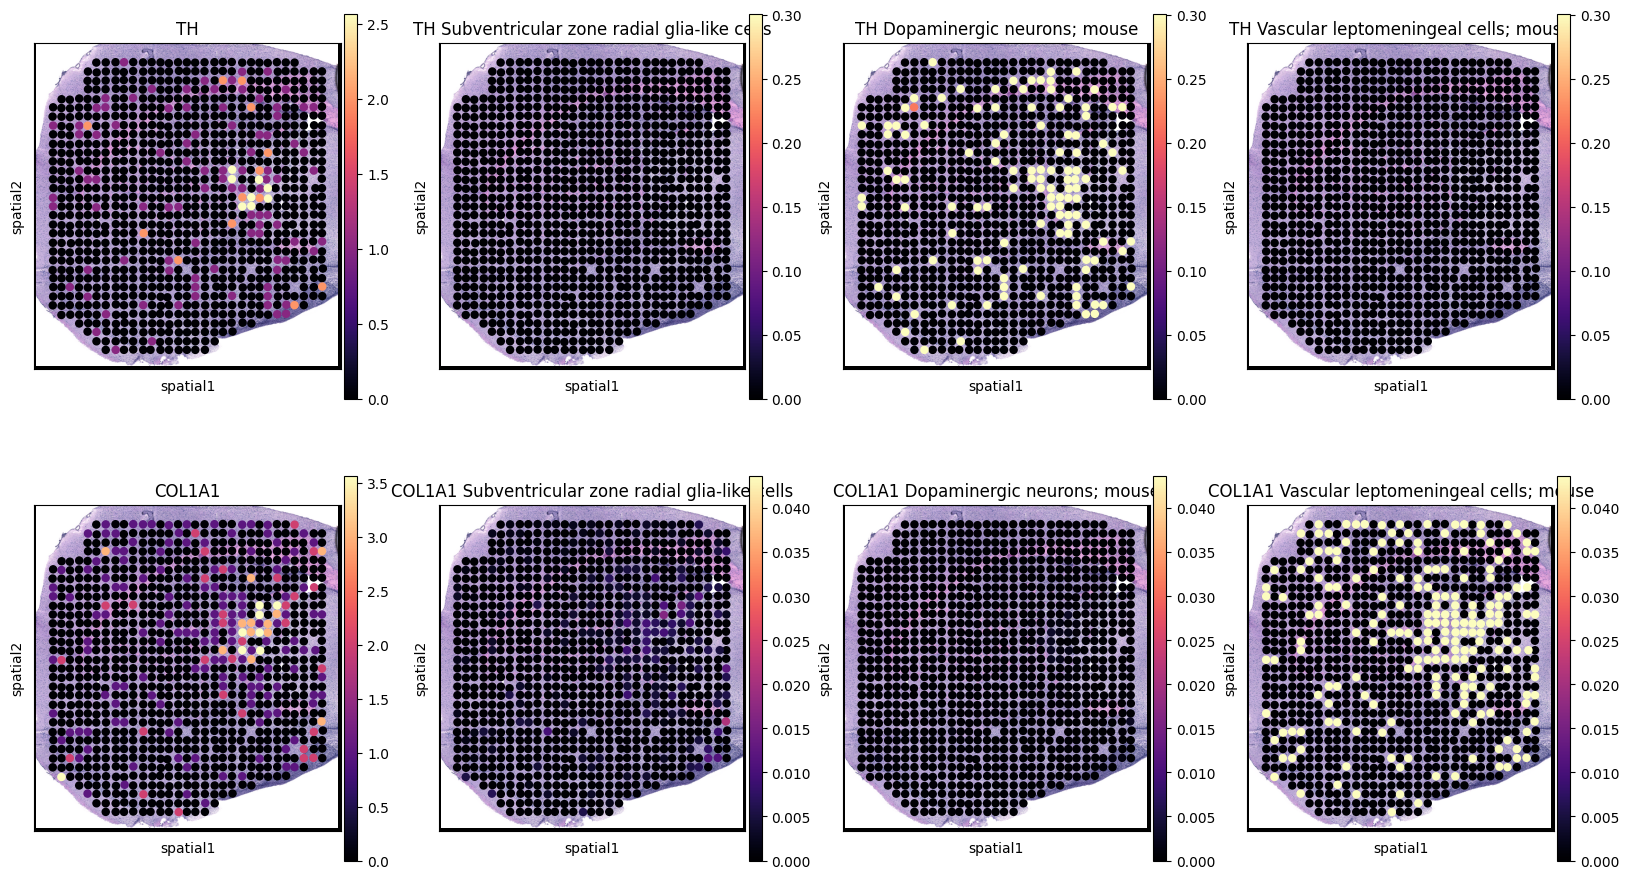

In [290]:
# list cell types and genes for plotting
ctypes = ['Subventricular zone radial glia-like cells', 
                'Dopaminergic neurons; mouse', 
                'Vascular leptomeningeal cells; mouse']
genes = ['TH', 'COL1A1']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'ST3_E1')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);